# Hands on: Robot Motion


In [1]:
import matplotlib
print("matplotlib version: ", matplotlib.__version__) # version 3.2.2 is tested
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.linalg import logm, expm
import os
import imageio
from IPython.display import HTML

folder = 'plots'
if not os.path.exists(folder):
    os.makedirs(folder)

matplotlib version:  3.5.3


## Example 1: Process model on Lie groups and uncertainty propagation using SE(2)

### Process model: $X_{k+1} = X_k U_k e^{w_k}$
Here $X_k, U_k \in$ SE(2) and $w_k \sim \mathcal{N}(0, Q_k)$ and defined in the lie algebra se(2). We use Monte Carlo methods to propagate samples over a path and then compute the sample mean and covariance on Lie group, here SE(2). Note that the sample mean and covariance are computed using an iterative algorithm which is different than usual Euclidean sample statistics. The covariance on Lie algebra is flat as expected but it's nonlinear when mapped to the manifold using Lie group.

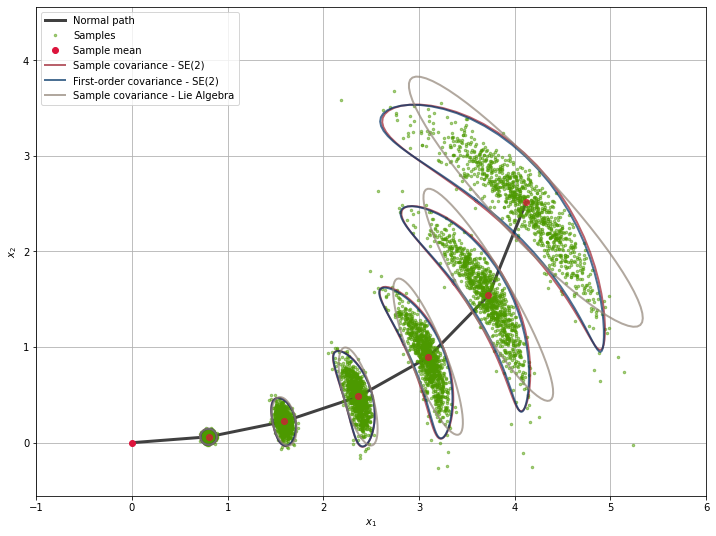

In [2]:
def adjoint(X):
    # SE(2) Adjoint function
    matrix = np.hstack((X[0:2, 0:2], np.array([[X[1, 2]], [-X[0, 2]]])))
    matrix = np.vstack((matrix, np.array([0, 0, 1])))
    return matrix


def pos_def_matrix(A):
    # Check input matrix is positive definite or not
    return np.all(np.linalg.eigvals(A) > 0)


def propagation(robot, u):
    # SE(2) propagation model
    # @param robot: robot structure
    # @param u: control input (x,y,theta)

    for i in range(robot['n']):
        #  sample from a zero mean Gaussian
        noise = robot['L'] @ np.random.randn(3, 1)
        N = robot['G1'] * noise[0] + robot['G2'] * noise[1] + robot['G3'] * noise[2]
        Ui = np.array([[np.cos(u[2]), -np.sin(u[2]), u[0]],
                       [np.sin(u[2]), np.cos(u[2]), u[1]],
                       [0, 0, 1]])
        robot['x'][i] = robot['x'][i] @ Ui @ expm(N)
    return robot


def Lie_sample_statistics(robot):
    # compute sample mean and covariance on matrix Lie group
    mu0 = robot['x'][0]  # pick a sample as initial guess
    v = np.copy(robot['x'])
    max_iter = 100
    iter = 1
    while iter < max_iter:
        mu = mu0 * 0
        Sigma = np.zeros([3, 3])
        for i in range(robot['n']):
            # left-invariant error: eta^L = X^(-1) * X^hat
            v[i] = logm(np.linalg.inv(mu0) @ robot['x'][i])
            mu = mu + v[i]
            vec_v = np.array([[v[i][0, 2]],
                              [v[i][1, 2]],
                              [v[i][1, 0]]])
            Sigma = Sigma + vec_v @ vec_v.T
        mu = mu0 @ expm(mu / robot['n'])
        Sigma = (1 / (robot['n'] - 1)) * Sigma  # unbiased sample covariance
        # check if we're done here
        temp = np.linalg.norm(logm(np.linalg.inv(mu0) @ mu))
        if temp < 1e-8:
            return mu, Sigma
        else:
            mu0 = np.copy(mu)
        iter += 1
    print('\033[91mWarning: Not converged! Max iteration reached. The statistic might not be reliable.\033[0m')


# generate a path
dt = 0.8
gt = {}
gt['x'] = np.arange(0, 4.5 + dt, dt)
gt['y'] = 0.1 * np.exp(0.6 * gt['x']) - 0.1

# find the headings tangent to the path
gt['h'] = []
gt['h'].append(0)
for i in range(1, len(gt['x'])):
    gt['h'].append(np.arctan2(gt['y'][i] - gt['y'][i - 1], gt['x'][i] - gt['x'][i - 1]))
gt['h'] = np.array(gt['h'])

# generate noise-free control inputs
u = np.zeros([3, len(gt['x']) - 1])
u[0, :] = np.diff(gt['x'])
u[1, :] = np.diff(gt['y'])
u[2, :] = np.diff(gt['h'])

# build a 2D robot
robot = {}
robot['dt'] = dt
robot['n'] = 1000 # sample number
robot['x'] = []  # state mean
robot['Cov_fo'] = np.zeros([3, 3])  # first order covariance propagation around mean
for i in range(robot['n']):
    robot['x'].append(np.eye(3))
# motion model noise covariance
robot['Q'] = np.diag([0.03 ** 2, 0.03 ** 2, 0.1 ** 2])
# Cholesky factor of covariance for sampling
robot['L'] = np.linalg.cholesky(robot['Q'])
# se(2) generators; twist = vec(v1, v2, omega)
robot['G1'] = np.array([[0, 0, 1],
                        [0, 0, 0],
                        [0, 0, 0]])
robot['G2'] = np.array([[0, 0, 0],
                        [0, 0, 1],
                        [0, 0, 0]])
robot['G3'] = np.array([[0, -1, 0],
                        [1, 0, 0],
                        [0, 0, 0]])
# SE(2) Adjoint
robot['Ad'] = adjoint

# construct noise free motion trajectory
path = {}
path['T'] = np.eye(3)
path['x'] = []
path['x'].append(0)
path['y'] = []
path['y'].append(0)
for i in range(u.shape[1]):
    Ui = np.array([[np.cos(u[2, i]), -np.sin(u[2, i]), u[0, i]],
                    [np.sin(u[2, i]), np.cos(u[2, i]), u[1, i]],
                    [0, 0, 1]])
    path['T'] = path['T'] @ Ui
    path['x'].append(path['T'][0, 2])
    path['y'].append(path['T'][1, 2])

# create confidence ellipse
# first create points from a unit circle + angle (third dimension of so(3))
phi = np.arange(-np.pi, np.pi + 0.1, 0.1).reshape(-1, 1)
circle = np.array([np.cos(phi), np.sin(phi), np.zeros([len(phi), 1])])
circle = circle.reshape(3, -1).T
# Chi-squared 3-DOF 95% confidence (0.05) : 7.815
scale = np.sqrt(7.815)

# incremental visualization
green = np.array([0.2980, 0.6, 0])
crimson = np.array([220, 20, 60]) / 255
darkblue = np.array([0, 0.2, 0.4])
Darkgrey = np.array([0.25, 0.25, 0.25])
VermillionRed = np.array([156, 31, 46]) / 255
DupontGray = np.array([144, 131, 118]) / 255

# plot the path
fig = plt.figure(figsize=(12, 9))
plt.plot(path['x'], path['y'], '-', color=Darkgrey, linewidth=3, label='Normal path')
plt.grid(True)
plt.axis('equal')
plt.xlim([-1, 6])
plt.ylim([-1, 5])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

# extract propagated particles
p = np.zeros([2, robot['n']])
for i in range(robot['n']):
    p[0, i] = robot['x'][i][0, 2]
    p[1, i] = robot['x'][i][1, 2]

# compute sample statistics
mu, Sigma = Lie_sample_statistics(robot)

# plot sample mean and particles
plt.plot(p[0, :], p[1, :], '.', color=green, alpha=0.5, markersize=5, label='Samples')
plt.plot(mu[0, 2], mu[1, 2], 'o', color=crimson, markersize=6, label='Sample mean')

# main loop; iterate over the control inputs and move the robot
ellipse_manifold = np.zeros([circle.shape[0], 2])  # covariance ellipse on manifold (nonlinear)
ellipse_first_order = np.zeros([circle.shape[0], 2])  # first order covariance ellipse on maniford (nonlinear)
ellipse_lie_algebra = np.zeros([circle.shape[0], 2])  # covariance ellipse on Lie algebra
show_label = True

for i in range(u.shape[1]):
    # move particles based on the input
    propagation(robot, u[:, i])

    # extract propagated particle positions
    p = np.zeros([2, robot['n']])
    for j in range(robot['n']):
        p[0, j] = robot['x'][j][0, 2]
        p[1, j] = robot['x'][j][1, 2]

    # show particles
    plt.plot(p[0, :], p[1, :], '.', color=green, alpha=0.5, markersize=5)

    # compute sample statistics
    mu, Sigma = Lie_sample_statistics(robot)


    # compute first order analytical covariance propagation
    Ui = np.array([[np.cos(u[2, i]), -np.sin(u[2, i]), u[0, i]],
                    [np.sin(u[2, i]), np.cos(u[2, i]), u[1, i]],
                    [0, 0, 1]])

    # left-invariant error: eta^L = X^-1 * X^hat
    # robot['Ad'](np.linalg.inv(Ui)) maps the covariance back to Lie algebra using the
    # incremental motion Ui (hence np.linalg.inv(Ui)). Then the noise covariance that
    # is already defined in Lie algebra can be added to the mapped state covariance
    robot['Cov_fo'] = robot['Ad'](np.linalg.inv(Ui)) @ robot['Cov_fo'] @ robot['Ad'](np.linalg.inv(Ui)).T + robot['Q']
    robot['L_fo'] = np.linalg.cholesky(robot['Cov_fo'])

    # create the ellipse using the unit circle
    # if Sigma is positive definite, plot the ellipse
    # otherwise, the shape is not ellipse
    if pos_def_matrix(Sigma):
        L = np.linalg.cholesky(Sigma)
        for j in range(circle.shape[0]):
            # contour 1: sample covariance on SE(2）
            ell_se2_vec = scale * L @ circle[j, :]
            # retract and left-translate the ellipse on Lie algebra to SE(2) using Lie exp map
            temp = robot['G1'] * ell_se2_vec[0] + robot['G2'] * ell_se2_vec[1] + robot['G3'] * ell_se2_vec[2]
            temp = mu @ expm(temp)
            ellipse_manifold[j, :] = np.array([temp[0, 2], temp[1, 2]])

            # contour 2: get the ellipse on Lie algebra
            temp = np.array([[np.cos(ell_se2_vec[2]), -np.sin(ell_se2_vec[2]), ell_se2_vec[0]],
                                    [np.sin(ell_se2_vec[2]), np.cos(ell_se2_vec[2]), ell_se2_vec[1]],
                                    [0, 0, 1]])
            temp = mu @ temp
            ellipse_lie_algebra[j, :] = np.array([temp[0, 2], temp[1, 2]])

            # sample covariance on SE(2)
            ell_se2_vec = scale * (robot['L_fo'] @ circle[j, :])
            # contour 3: retract and left-translate the ellipse on Lie algebra to SE(2) using Lie exp map
            temp = expm(robot['G1'] * ell_se2_vec[0] + robot['G2'] * ell_se2_vec[1] + robot['G3'] * ell_se2_vec[2])
            temp = mu @ temp
            ellipse_first_order[j, :] = np.array([temp[0, 2], temp[1, 2]])
        if show_label:
            plt.plot(ellipse_manifold[:, 0], ellipse_manifold[:, 1], color=VermillionRed, alpha=0.7, linewidth=2,
                      label='Sample covariance - SE(2)')
            plt.plot(ellipse_first_order[:, 0], ellipse_first_order[:, 1], color=darkblue, alpha=0.7, linewidth=2,
                      label='First-order covariance - SE(2)')
            plt.plot(ellipse_lie_algebra[:, 0], ellipse_lie_algebra[:, 1], color=DupontGray, alpha=0.7, linewidth=2,
                      label='Sample covariance - Lie Algebra')
            show_label = False
        else:
            plt.plot(ellipse_manifold[:, 0], ellipse_manifold[:, 1], color=VermillionRed, alpha=0.7, linewidth=2)
            plt.plot(ellipse_first_order[:, 0], ellipse_first_order[:, 1], color=darkblue, alpha=0.7, linewidth=2)
            plt.plot(ellipse_lie_algebra[:, 0], ellipse_lie_algebra[:, 1], color=DupontGray, alpha=0.7, linewidth=2)
            
    plt.plot(mu[0, 2], mu[1, 2], 'o', color=crimson, alpha=0.7, markersize=6)
    plt.legend(loc='upper left') 
    # plt.pause(0.05)
    filename = os.path.join(folder, f'example1_plot_{i}.png')
    plt.savefig(filename)
    # plt.clf()

fig.savefig('banana_is_gaussian.png')
plt.show()

In [3]:
# example for understand contour 1
w = [1, 0, np.pi/2] # v_x=1, omega=pi/2
temp = robot['G1'] * w[0] + robot['G2'] * w[1] + robot['G3'] * w[2]
print("integrate over time:\n",expm(temp))

# example for understand contour 2
temp = np.array([[np.cos(w[2]), -np.sin(w[2]), w[0]],
                [np.sin(w[2]), np.cos(w[2]), w[1]],
                [0, 0, 1]])
print("directly use transform:\n", temp)

integrate over time:
 [[ 0.         -1.          0.63661977]
 [ 1.          0.          0.63661977]
 [ 0.          0.          1.        ]]
directly use transform:
 [[ 6.123234e-17 -1.000000e+00  1.000000e+00]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]


In [4]:
# create a gif
images = []
for i in range(u.shape[1]):
    filename = os.path.join(folder, f'example1_plot_{i}.png')
    images.append(imageio.imread(filename))
imageio.mimsave('example1_plots.gif', images)

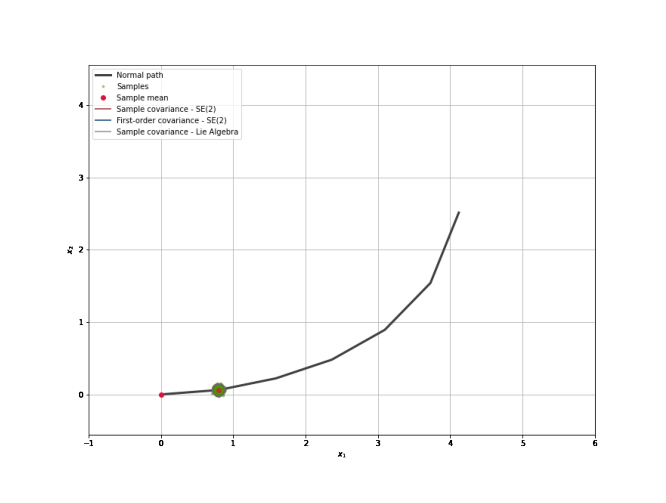

In [5]:
fig = plt.figure(figsize=(12, 9))
fig.set_frameon(False)

def update(i):
    filename = os.path.join(folder, f'example1_plot_{i}.png')
    image = plt.imread(filename)
    plt.axis("off")
    plt.imshow(image)

ani = animation.FuncAnimation(fig, update, frames=u.shape[1])
# make the figure larger
HTML(ani.to_jshtml())

## Example 2: Velocity-based motion model on SE(2)
### Process model: $X_{k+1} = X_{k}e^{u_k+w_k}$.
Where $X_k$ is in SE(2), $u_k$ is the twist in se(2), $w_k \sim \mathcal{N}(0, Q_k)$ and defined in the Lie algebra se(2).

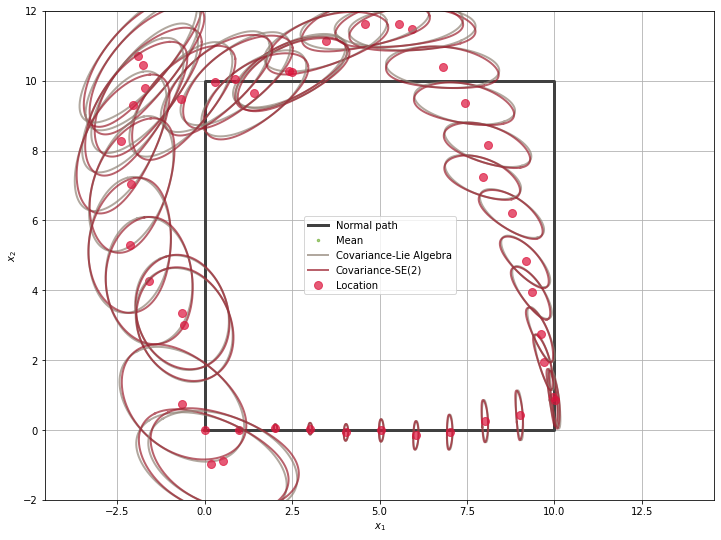

In [8]:
def posemat(x, y, h):
    # construct a SE(2) matrix element
    H = np.array([[np.cos(h), -np.sin(h), x],
                  [np.sin(h), np.cos(h), y],
                  [0, 0, 1]])
    return H


def adjoint(X):
    # SE(2) Adjoint
    matrix = np.hstack((X[0:2, 0:2], np.array([[X[1, 2]], [-X[0, 2]]])))
    matrix = np.vstack((matrix, np.array([0, 0, 1])))
    return matrix


def propagation(robot, u):
    # SE(2) propagation model; the input is u \in se(2) plus noise
    # sample from a zero mean Gaussian
    noise = robot['L'] @ np.random.randn(3, 1)
    N = robot['G1'] * noise[0] + robot['G2'] * noise[1] + robot['G3'] * noise[2]
    xi = u + N
    # propagate mean
    robot['x'] = robot['x'] @ expm(xi)
    # propagate covariance
    robot['Cov'] = robot['Ad'](expm(-xi)) @ robot['Cov'] @ robot['Ad'](expm(-xi)).T + robot['Q']
    return robot


# generate a path
dt = 1
gt = {}
n = len(np.arange(0, 10+dt, dt))
gt['x'] = np.hstack((np.arange(0, 10+dt, dt).reshape(1, -1), 10 * np.ones([1, n]),
                      np.arange(10, 0-dt, -dt).reshape(1, -1), np.zeros([1, n])))
gt['y'] = np.hstack((np.zeros([1, n]), np.arange(0, 10+dt, dt).reshape(1, -1),
                      10 * np.ones([1, n]), np.arange(10, 0-dt, -dt).reshape(1, -1)))

# find the headings tangent to the path
gt['h'] = []
gt['h'].append(0)
for i in range(1, gt['x'].shape[1]):
    gt['h'].append(np.arctan2(gt['y'][0, i] - gt['y'][0, i-1], gt['x'][0, i] - gt['x'][0, i-1]))

# ground truth poses
H = [np.eye(3)]
for i in range(1, gt['x'].shape[1]):
    H.append(posemat(gt['x'][0, i], gt['y'][0, i], gt['h'][i]))

# generate noise=free twist control inputs (velocity commands) in the Lie algebra
u = [np.zeros([3, 3])]
for i in range(1, gt['x'].shape[1]):
    logm_temp = np.array(logm(np.linalg.inv(H[i-1]) @ H[i]))
    for m in range(logm_temp.shape[0]):
        for n in range(logm_temp.shape[1]):
            if np.iscomplex(logm_temp[m, n]):
                logm_temp = np.imag(logm_temp)
                temp = np.copy(logm_temp[1, :])
                logm_temp[1, :] = logm_temp[0, :]
                logm_temp[0, :] = -temp.reshape(1, -1)
                pass
    u.append(logm_temp)

# construct noise free motion trajectory (sanity check for the generated inputs)
path = {}
path['T'] = H[0]
path['x'] = [0, 0]
path['y'] = [0, 0]
for i in range(1, len(u)):
    path['T'] = path['T'] @ expm(u[i])
    path['x'].append(path['T'][0, 2])
    path['y'].append(path['T'][1, 2])

# build a 2D robot!
robot = {}
robot['dt'] = dt
robot['x'] = np.eye(3)  # state mean
robot['Cov'] = np.zeros([3, 3])  # covariance
# motion model noise covariance
robot['Q'] = np.diag([0.01 ** 2, 0.01 ** 2, 0.015 ** 2])
# Cholesky factor of covariance for sampling
robot['L'] = np.linalg.cholesky(robot['Q'])
# se(2) generators; twist = vect(v1, v2, omega)
robot['G1'] = np.array([[0, 0, 1],
                        [0, 0, 0],
                        [0, 0, 0]])
robot['G2'] = np.array([[0, 0, 0],
                        [0, 0, 1],
                        [0, 0, 0]])
robot['G3'] = np.array([[0, -1, 0],
                        [1, 0, 0],
                        [0, 0, 0]])
# SE(2) Adjoint
robot['Ad'] = adjoint

# create confidence ellipse
# first create points from a unit circle + angle (third dimension of so(3))
phi = np.arange(-np.pi, np.pi+0.01, 0.01)
circle = np.array([np.cos(phi).reshape(-1, 1), np.sin(phi).reshape(-1, 1), np.zeros([len(phi), 1])]).reshape(3, -1)
# Chi-squared 3-DOF 95% confidence (0.05):7.815
scale = np.sqrt(7.815)

# incremental visualization
green = np.array([0.2980, 0.6, 0])
crimson = np.array([220, 20, 60]) / 255
darkblue = np.array([0, 0.2, 0.4])
Darkgrey = np.array([0.25, 0.25, 0.25])
VermillionRed = np.array([156, 31, 46]) / 255
DupontGray = np.array([144, 131, 118]) / 255

fig = plt.figure(figsize=(12, 9))
plt.grid(True)
plt.axis('equal')
plt.xlim([-2, 12])
plt.ylim([-2, 12])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
# plot Normal path
plt.plot(path['x'], path['y'], '-', color=Darkgrey, linewidth=3, label='Normal path')

# plot initial mean
plt.plot(robot['x'][0, 2], robot['x'][1, 2], '.', color=green, alpha=0.5, markersize=5, label='Mean')

# main loop; iterate over the control inputs and move the robot
ellipse_manifold = np.zeros([circle.shape[1], 2])  # covariance ellipse on manifold (nonlinear)
ellipse_lie_algebra = np.zeros([circle.shape[1], 2])  # covariance ellipse on Lie algebra

plot_legend = True

for i in range(len(u)):
    plt.grid(True)
    plt.axis('equal')
    plt.xlim([-2, 12])
    plt.ylim([-2, 12])
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    # move the robot based on the input
    robot = propagation(robot, u[i])
    robot['L'] = np.linalg.cholesky(robot['Cov'])
    for j in range(circle.shape[1]):
        # sample covariance on SE(2)
        ell_se2_vec = scale * robot['L'] @ circle[:, j]
        # contour 1: retract and left-translate the ellipse on Lie algebra to SE(2) using Lie exp map
        temp = robot['G1'] * ell_se2_vec[0] + robot['G2'] * ell_se2_vec[1] + robot['G3'] * ell_se2_vec[2]
        temp = robot['x'] @ expm(temp)
        ellipse_manifold[j, :] = np.array([temp[0, 2], temp[1, 2]])

        # contour 2: get the ellipse on Lie algebra
        temp = np.array([[np.cos(ell_se2_vec[2]), -np.sin(ell_se2_vec[2]), ell_se2_vec[0]],
                                [np.sin(ell_se2_vec[2]), np.cos(ell_se2_vec[2]), ell_se2_vec[1]],
                                [0, 0, 1]])
        temp = robot['x'] @ temp
        ellipse_lie_algebra[j, :] = np.array([temp[0, 2], temp[1, 2]])
    if plot_legend:
        plt.plot(ellipse_lie_algebra[:, 0], ellipse_lie_algebra[:, 1], color=DupontGray, alpha=0.7, linewidth=2, label='Covariance-Lie Algebra')
        plt.plot(ellipse_manifold[:, 0], ellipse_manifold[:, 1], color=VermillionRed, alpha=0.7, linewidth=2, label='Covariance-SE(2)')
        plt.plot(robot['x'][0, 2], robot['x'][1, 2], 'o', color=crimson, alpha=0.7, markersize=8, label='Location')
        plot_legend=False
    else:
        plt.plot(ellipse_lie_algebra[:, 0], ellipse_lie_algebra[:, 1], color=DupontGray, alpha=0.7, linewidth=2)
        plt.plot(ellipse_manifold[:, 0], ellipse_manifold[:, 1], color=VermillionRed, alpha=0.7, linewidth=2)
        plt.plot(robot['x'][0, 2], robot['x'][1, 2], 'o', color=crimson, alpha=0.7, markersize=8)
    plt.legend(loc='center')
    filename = os.path.join(folder, f'example2_plot_{i}.png')
    plt.savefig(filename)
    # plt.clf() 

fig.savefig('banana_is_gaussian_rect.png')
plt.show()

In [9]:
# create a gif
images = []
for i in range(len(u)):
    filename = os.path.join(folder, f'example2_plot_{i}.png')
    images.append(imageio.imread(filename))
imageio.mimsave('example2_plots.gif', images)

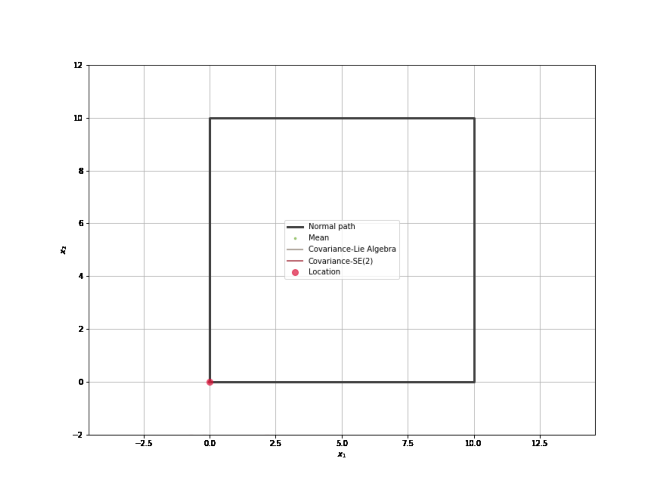

In [10]:
# Animation
fig = plt.figure(figsize=(12, 9))
fig.set_frameon(False)

def update(i):
    filename = os.path.join(folder, f'example2_plot_{i}.png')
    image = plt.imread(filename)
    plt.axis('off')
    plt.imshow(image)

ani = animation.FuncAnimation(fig, update, frames=len(u))
HTML(ani.to_jshtml())

## Example 3: Process model on Lie groups and uncertainty propagation using SE(3)
Process model: $X_{k+1} = X_k e^{U_k + w_k}$.  
Where $X_k$ is in SE(3) and $U_k, w_k$ defined in Lie algebra se(3)

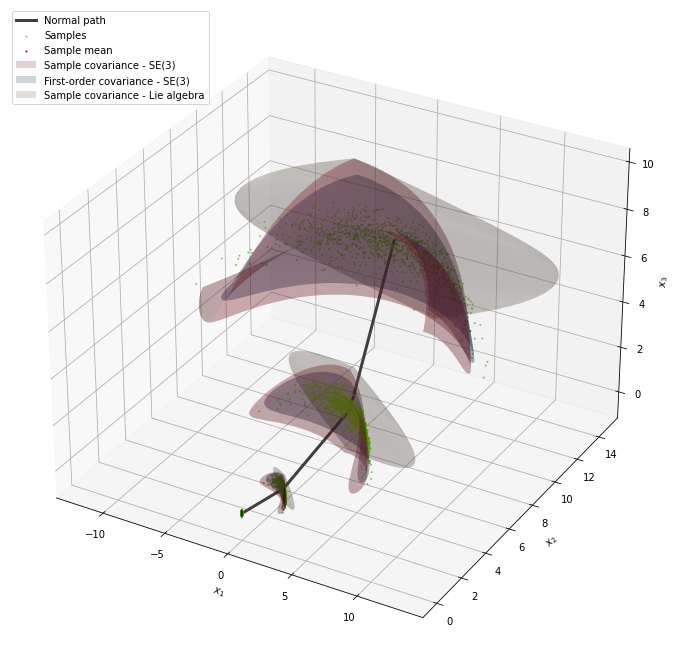

In [11]:
def Rx(roll):
    # Rotation matrix about X axis (roll)
    # Input:
    #   roll:   angle in radian about X axis
    # Output:
    #   H:  3D rotation matrix
    sr = np.sin(roll)
    cr = np.cos(roll)

    H = np.array([[1, 0, 0],
                  [0, cr, -sr],
                  [0, sr, cr]])
    return H


def Ry(pitch):
    # Rotation matrix about Y axis(pitch)
    # Input:
    #   pitch:   angle in radian about Y axis
    # Output:
    #   H:  3D rotation matrix
    sp = np.sin(pitch)
    cp = np.cos(pitch)

    H = np.array([[cp, 0, sp],
                  [0, 1, 0],
                  [-sp, 0, cp]])

    return H


def Rz(yaw):
    # Rotation matrix about Z axis(yaw)
    # Input:
    #   yaw:   angle in radian about Z axis
    # Output:
    #   H:  3D rotation matrix
    sy = np.sin(yaw)
    cy = np.cos(yaw)

    H = np.array([[cy, -sy, 0],
                  [sy, cy, 0],
                  [0, 0, 1]])

    return H


def Rzyx(yaw, pitch, roll):
    # Rotation matrix for yaw pitch roll angles
    # Order of rotation R = Rz * Ry * Rx
    # Extrinsic rotations; The XYZ system rotates, while xyz is fixed
    # Verifeid using MATLAB rotm = eul2rotm([yaw, pitch, roll], 'ZYX')
    # Input:
    #   yaw, pitch, roll:   rotation angles (radian) about Z, Y, X
    # Output:
    #   R: 3D rotation matrix
    R = Rz(yaw) @ Ry(pitch) @ Rx(roll)
    return R

def pos_def_matrix(A):
    # Check input matrix is positive definite or not
    return np.all(np.linalg.eigvals(A) > 0)    

def adjoint(X):
    # SE(3) Adjoint
    matrix = np.hstack((X[0:3, 0:3], skew(X[0:3, 3]) @ X[0:3, 0:3]))
    matrix = np.vstack((matrix, np.hstack((np.zeros([3, 3]), X[0:3, 0:3]))))
    return matrix

def skew(x):
    # vector to skew R^3 -> so(3)
    matrix = np.array([[0, -x[2], x[1]],
                       [x[2], 0, -x[0]],
                       [-x[1], x[0], 0]])
    return matrix


def unskew(A):
    # so(3) -> R^3
    return np.array([[A[2, 1]], [A[0, 2]], [A[1, 0]]])


def hat(x):
    # hat: R^6 -> se(3)
    matrix = np.hstack((skew(x[3:6]), x[0:3].reshape(-1, 1)))
    matrix = np.vstack((matrix, np.array([0, 0, 0, 0])))
    return matrix


def wedge(X):
    # wedge: se(3) -> R^6
    matrix = np.vstack((X[0:3, 3].reshape(-1, 1), unskew(X[0:3, 0:3])))
    return matrix


def propagation(robot, u):
    # SE(3) propagation model; each input is U \in se(3) plus exp map of the
    # noise define in Lie algebra
    Ui = u[0] * robot['G1'] + u[1] * robot['G2'] + u[2] * robot['G3'] \
         + u[3] * robot['G4'] + u[4] * robot['G5'] + u[5] * robot['G6']
    for i in range(robot['n']):
        # sample from a zero mean Gausian
        noise = robot['L'] @ np.random.randn(6, 1)
        N = noise[0] * robot['G1'] + noise[1] * robot['G2'] + noise[2] * robot['G3'] \
            + noise[3] * robot['G4'] + noise[4] * robot['G5'] + noise[5] * robot['G6']
        robot['x'][i] = robot['x'][i] @ expm(Ui + N)
    return robot


def Lie_sample_statistics(robot):
    # compute sample mean and covariance on matrix Lie group
    mu0 = robot['x'][0]  # pick a sample as initial guess
    v = np.copy(robot['x'])
    max_iter = 100
    iter = 1
    while iter < max_iter:
        mu = mu0 * 0
        Sigma = np.zeros([6, 1])
        for i in range(robot['n']):
            # left-invariant error: eta^L = X^-1 * X^hat
            v[i] = logm(np.linalg.inv(mu0) @ robot['x'][i])
            mu = mu + v[i]
            vec_v = wedge(v[i])
            Sigma = Sigma + vec_v @ vec_v.T
        mu = mu0 @ expm(mu / robot['n'])
        Sigma = (1 / (robot['n'] - 1)) * Sigma  # unbiased sample covariance
        # check if we are done here
        temp = np.linalg.norm(logm(np.linalg.inv(mu0) @ mu))
        if temp < 1e-8:
            return mu, Sigma
        else:
            mu0 = np.copy(mu)
        iter += 1
    print('\033[91mWarning: Not converged! Max iteration reached. The statistic might not be reliable.\033[0m')

# se(3) generators; twist = vec(v, omega).
# R^3 standard basis
e1 = np.array([1, 0, 0])
e2 = np.array([0, 1, 0])
e3 = np.array([0, 0, 1])

# so(3) (SO(3) Lie algebra) infinitesimal generator
robot = {}
robot['G1'] = np.zeros([4, 4])
robot['G1'][0, 3] = 1

robot['G2'] = np.zeros([4, 4])
robot['G2'][1, 3] = 1

robot['G3'] = np.zeros([4, 4])
robot['G3'][2, 3] = 1

robot['G4'] = np.hstack((skew(e1), np.zeros([3, 1])))
robot['G4'] = np.vstack((robot['G4'], np.zeros([1, 4])))

robot['G5'] = np.hstack((skew(e2), np.zeros([3, 1])))
robot['G5'] = np.vstack((robot['G5'], np.zeros([1, 4])))

robot['G6'] = np.hstack((skew(e3), np.zeros([3, 1])))
robot['G6'] = np.vstack((robot['G6'], np.zeros([1, 4])))

# SE(3) Adjoint
robot['Ad'] = adjoint

# generate noise-free control inputs in Lie algebra se(3)
nstep = 4
u = []
u.append(np.linspace(0, 4, nstep))
u.append(1.5 * u[0])
u.append(0.05 * np.exp(0.6 * u[0]) - 0.05)
u.append(np.linspace(0, 0.5, nstep))
u.append(np.linspace(0, 0.3, nstep))
u.append(np.linspace(0, 0.7, nstep))
u = np.array(u)

# build a 3D robot!
robot['n'] = 1000
robot['x'] = []  # state mean
robot['Cov_fo'] = np.zeros([6, 6])  # first order covariance propagation around mean
for i in range(robot['n']):
    robot['x'].append(np.eye(4))
# motion model noise covariance
robot['Q'] = np.diag(np.power([0.01, 0.01, 0.05, 0.05, 0.05, 0.2], 2))
# Cholesky factor of covariance for sampling
robot['L'] = np.linalg.cholesky(robot['Q'])

# construct noise free motion trajectory
path = {}
path['T'] = np.eye(4)
path['x'] = [0]
path['y'] = [0]
path['z'] = [0]
for i in range(u.shape[1]):
    Ui = u[0, i] * robot['G1'] + u[1, i] * robot['G2'] + u[2, i] * robot['G3'] \
          + u[3, i] * robot['G4'] + u[4, i] * robot['G5'] + u[5, i] * robot['G6']
    path['T'] = path['T'] @ expm(Ui)
    path['x'].append(path['T'][0, 3])
    path['y'].append(path['T'][1, 3])
    path['z'].append(path['T'][2, 3])

# create confidence ellipsoid
# first create points from a unit sphere
phi = np.linspace(-np.pi, np.pi, 100)
theta = np.linspace(-np.pi / 2, np.pi / 2, 100)
PHI, THETA = np.meshgrid(phi, theta)
X_sph = np.cos(THETA) * np.cos(PHI)
Y_sph = np.sin(THETA) * np.sin(PHI)
Z_sph = np.sin(THETA)
sphere = np.array([X_sph.reshape(-1), Y_sph.reshape(-1), Z_sph.reshape(-1)])
sphere = np.vstack((sphere, np.zeros(sphere.shape))).T
# Chi-squared 6-DOF 95% confidence (0.05): 12.592
scale = np.sqrt(12.592)

# incremental visualization
green = np.array([0.2980, 0.6, 0])
crimson = np.array([220, 20, 60]) / 255
darkblue = np.array([0, 0.2, 0.4])
Darkgrey = np.array([0.25, 0.25, 0.25])
VermillionRed = np.array([156, 31, 46]) / 255
DuponGray = np.array([144, 131, 118]) / 255

# plotting
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.plot3D(path['x'], path['y'], path['z'], '-', color=Darkgrey, linewidth=3, label='Normal path')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$x_3$')

# extract propagated particles
p = np.zeros([3, robot['n']])
for i in range(robot['n']):
    p[0, i] = robot['x'][i][0, 3]
    p[1, i] = robot['x'][i][1, 3]
    p[2, i] = robot['x'][i][2, 3]

# compute sample statistics
mu, Sigma = Lie_sample_statistics(robot)

# plot sample mean and particles
ax.scatter3D(p[0, :], p[1, :], p[2, :], '.', color=green, alpha=0.5, s=1, label='Samples')
ax.scatter3D(mu[0, 3], mu[1, 3], mu[2, 3], 'o', color=crimson, s=1.5, label='Sample mean')

# main loop; iterate over the control inputs and move the robot
ellipsoid_manifold = np.zeros([sphere.shape[0], 3])  # covariance ellipse on manifold (nonlinear)
ellipsoid_first_order = np.zeros([sphere.shape[0], 3])  # first order covariance ellipse on manifold (nonlinear)
ellipsoid_lie_algebra = np.zeros([sphere.shape[0], 3])  # covariance ellipse on Lie algebra
plot_label = True

for i in range(u.shape[1]):
    # move particles based on input
    robot = propagation(robot, u[:, i])
    # extract propagated particles
    p = np.zeros([3, robot['n']])
    for j in range(robot['n']):
        p[0, j] = robot['x'][j][0, 3]
        p[1, j] = robot['x'][j][1, 3]
        p[2, j] = robot['x'][j][2, 3]

    # show particles
    ax.scatter3D(p[0, :], p[1, :], p[2, :], '.', color=green, alpha=0.5, s=1)

    # compute sample statistics
    mu, Sigma = Lie_sample_statistics(robot)

    # compute first order analytical covariance propagation
    Ui = expm(u[0, i] * robot['G1'] + u[1, i] * robot['G2'] + u[2, i] * robot['G3']
              + u[3, i] * robot['G4'] + u[4, i] * robot['G5'] + u[5, i] * robot['G6'])

    # left-invariant error: eta^L = X^-1 * X^hat
    # robot.Ad(inv(Ui)) maps the covariance back to Lie algebra using the
    # incremental motion Ui (hence inv(Ui)). Then the noise covariance that
    # is already defined in Lie algebra can be added to the mapped state covariance
    temp_value = robot['Ad'](np.linalg.inv(Ui))
    robot['Cov_fo'] = temp_value @ robot['Cov_fo'] @ temp_value.T + robot['Q']
    robot['L_fo'] = np.linalg.cholesky(robot['Cov_fo'])

    # create the ellipse using the unit circle
    if pos_def_matrix(Sigma):
        for j in range(sphere.shape[0]):
            L = np.linalg.cholesky(Sigma)
            # sample covariance on SE(2)
            ell_se3_vec = scale * L @ sphere[j, :]
            # retract and left-translate the ellipse on Lie algebra to SE(3) using Lie exp map
            temp = robot['G1'] * ell_se3_vec[0] + robot['G2'] * ell_se3_vec[1] + \
                    robot['G3'] * ell_se3_vec[2] + robot['G4'] * ell_se3_vec[3] + \
                    robot['G5'] * ell_se3_vec[4] + robot['G6'] * ell_se3_vec[5]
            temp = mu @ expm(temp)
            ellipsoid_manifold[j, :] = np.array([temp[0, 3], temp[1, 3], temp[2, 3]])

            # get the ellipse on Lie algebra
            temp_matrix = np.hstack(([Rzyx(ell_se3_vec[3], ell_se3_vec[4], ell_se3_vec[5]), ell_se3_vec[0:3].reshape(-1, 1)]))
            temp_matrix = np.vstack((temp_matrix, np.array([0, 0, 0, 1])))
            temp = mu @ temp_matrix
            ellipsoid_lie_algebra[j, :] = np.array([temp[0, 3], temp[1, 3], temp[2, 3]])

            # sample covariance on SE(3)
            ell_se3_vec = scale * robot['L_fo'] @ sphere[j, :]
            # retract and left-translate the ellipse on Lie algebra to SE(3) using Lie exp map
            temp = robot['G1'] * ell_se3_vec[0] + robot['G2'] * ell_se3_vec[1] + \
                    robot['G3'] * ell_se3_vec[2] + robot['G4'] * ell_se3_vec[3] + \
                    robot['G5'] * ell_se3_vec[4] + robot['G6'] * ell_se3_vec[5]
            temp = mu @ expm(temp)
            ellipsoid_first_order[j, :] = np.array([temp[0, 3], temp[1, 3], temp[2, 3]])

        # plot the ellipsoid
        # extract x, y, z matrices for plotting
        X_ell = ellipsoid_manifold[:, 0].reshape(X_sph.shape)
        Y_ell = ellipsoid_manifold[:, 1].reshape(Y_sph.shape)
        Z_ell = ellipsoid_manifold[:, 2].reshape(Z_sph.shape)
        if plot_label:
            surf1 = ax.plot_surface(X_ell, Y_ell, Z_ell, color=VermillionRed, alpha=0.2,
                                    label='Sample covariance - SE(3)')
        else:
            surf1 = ax.plot_surface(X_ell, Y_ell, Z_ell, color=VermillionRed, alpha=0.2)
        
        # read this if you encounter the error: AttributeError: 'Poly3DCollection' object has no attribute 'facecolors2d'
        # https://stackoverflow.com/questions/54994600/pyplot-legend-poly3dcollection-object-has-no-attribute-edgecolors2d
        surf1._facecolors2d = surf1._facecolor3d
        surf1._edgecolors2d = surf1._edgecolor3d

        # extract x, y, z matrices for plotting
        X_ell = ellipsoid_first_order[:, 0].reshape(X_sph.shape)
        Y_ell = ellipsoid_first_order[:, 1].reshape(Y_sph.shape)
        Z_ell = ellipsoid_first_order[:, 2].reshape(Z_sph.shape)
        if plot_label:
            surf2 = ax.plot_surface(X_ell, Y_ell, Z_ell, color=darkblue, alpha=0.2,
                                    label='First-order covariance - SE(3)')
        else:
            surf2 = ax.plot_surface(X_ell, Y_ell, Z_ell, color=darkblue, alpha=0.2)
        surf2._facecolors2d = surf2._facecolor3d
        surf2._edgecolors2d = surf2._edgecolor3d

        # extract x, y, z matrices for plotting
        X_ell = ellipsoid_lie_algebra[:, 0].reshape(X_sph.shape)
        Y_ell = ellipsoid_lie_algebra[:, 1].reshape(Y_sph.shape)
        Z_ell = ellipsoid_lie_algebra[:, 2].reshape(Z_sph.shape)
        if plot_label:
            surf3 = ax.plot_surface(X_ell, Y_ell, Z_ell, color=DuponGray, alpha=0.2,
                                    label='Sample covariance - Lie algebra')
            plot_label = False
        else:
            ax.plot_surface(X_ell, Y_ell, Z_ell, color=DuponGray, alpha=0.2)
        surf3._facecolors2d = surf3._facecolor3d
        surf3._edgecolors2d = surf3._edgecolor3d

    ax.scatter3D(mu[0, 3], mu[1, 3], mu[2, 3], 'o', color=crimson, alpha=0.7, s=1.5)
    plt.legend(loc='upper left')
fig.savefig('banana_is_gaussian_se3.png')
plt.show()